# Imports and Constants

In [68]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn import model_selection
from matplotlib import pyplot as plt

import PIL

# https://github.com/tensorflow/tensorflow/issues/46840
# https://stackoverflow.com/a/68239032/12405558
if PIL.__version__ == "8.3.0":
    raise ImportError(f"PIL 8.3.0 is incompatible with tensorflow 2.6.0")

abspath_join = lambda a, *p: os.path.abspath(os.path.join(a, *p))

BASE_DATA_DIR = "./data"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "train")
TEST_DIR = os.path.join(BASE_DATA_DIR, "test")

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

# Split training into training and validation dataset
VALIDATION_SIZE = 0.2

BATCH_SIZE = 20
EPOCHS = 1

CAT_TO_BIN = {"cat": 0, "dog": 1}
BIN_TO_CAT = {v: k for (k, v) in CAT_TO_BIN.items()}


'd:\\Code\\Python\\2.3-AI-CNN\\data\\test'

# Prepare Training Data

## Setup for Google Colab

In [ ]:
try:
    from google.colab import drive
    from zipfile import ZipFile
    
    MOUNT = "/content/drive"
    drive.mount(MOUNT, force_remount=True)

    BASE_DATA_DIR = "/content/data"
    TRAIN_DIR = abspath_join(BASE_DATA_DIR, "train")
    TEST_DIR = abspath_join(BASE_DATA_DIR, "test1")
    for zip_name in ("test1.zip","train.zip"):
        try:
            zip_dir = abspath_join(MOUNT, "MyDrive/AI/data", zip_name)
            with ZipFile(zip_dir, "r") as zip_ref:
                print(f"Unzipping {zip_name}")
                zip_ref.extractall(BASE_DATA_DIR)
        except:
            print(f"{zip_name} not found")
except ImportError:
    pass

## Setup for Kaggle

In [ ]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", None):
    from glob import glob
    from zipfile import ZipFile

    print("Extracting the data from dataset...")
    zip_files = glob("/kaggle/input/dogs-vs-cats/*.zip")
    print(f"{len(zip_files)} files found in the input directory")
    for file in zip_files:
        print(f"Unzipping {file.split('/')[-1]}")
        with ZipFile(file, "r") as Z:
            Z.extractall("data")
        print("Done")
    BASE_DATA_DIR = "/kaggle/working/data"
    TRAIN_DIR = abspath_join(BASE_DATA_DIR, "train")
    TEST_DIR = abspath_join(BASE_DATA_DIR, "test1")


In [ ]:
train_set = os.listdir(TRAIN_DIR)
types = [filename.split(".")[0] for filename in train_set]
df = pd.DataFrame({"filename": train_set, "class": types})

train_df, val_df = model_selection.train_test_split(df, test_size=VALIDATION_SIZE)

TOTAL_TRAIN = train_df.shape[0]
TOTAL_VAL = val_df.shape[0]

len(train_set)

## Some samples

In [ ]:
df["class"].value_counts() #.rename({v: k for k, v in CAT_TO_BIN.items()})

In [ ]:
print(f"Training: {len(train_df)}")
train_df.reset_index(drop=True)["class"].value_counts()

In [ ]:
print(f"Validation: {len(val_df)}")
val_df.reset_index(drop=True)["class"].value_counts()

# Build Model

In [ ]:
from tensorflow.keras import models, layers, losses

# https://www.tensorflow.org/guide/keras/functional
img_input = layers.Input(shape=IMG_SHAPE)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, (3, 3), activation="relu")(img_input)
x = layers.MaxPool2D((2, 2))(x)  # Stack layer

# Same as previous convolution but with 32 filters
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Dropout(0.25)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation="relu")(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation="sigmoid")(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + 
# fully connected layer + sigmoid output layer
model = models.Model(img_input, output)

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

## Model diagram

In [ ]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATAGEN_PARAMS = {
    "rescale": 1.0 / 255,
    "horizontal_flip": True,
    "zoom_range": 0.1,
    "rotation_range": 35,
    "height_shift_range": 0.2,
    "width_shift_range": 0.2,
}

GEN_PARAMS = {
    "directory": TRAIN_DIR,
    "target_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "class_mode": "binary",
}

train_datagen = ImageDataGenerator(**DATAGEN_PARAMS)
val_datagen = ImageDataGenerator(**DATAGEN_PARAMS)

train_gen = train_datagen.flow_from_dataframe(train_df, **GEN_PARAMS)
val_gen = val_datagen.flow_from_dataframe(val_df, **GEN_PARAMS)


Here we take an image and see how our `ImageDataGenerator` augment the image for each epoch (assume that `steps_per_epoch=TOTAL_TRAIN // BATCH_SIZE`)    

Detail here: https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset

In [ ]:
GEN_PARAMS.pop("class_mode", None)
SHAPE = (2,5)
FIGSIZE = (20,8)
IMG_IDX = None
if IMG_IDX is None: # Pick random
    sample_df = train_df.sample(n=1).reset_index()
else:
    sample_df = train_df.loc[[IMG_IDX], :]
sample_gen = train_datagen.flow_from_dataframe(
    sample_df,
    **GEN_PARAMS,
)

fig = plt.figure(figsize=FIGSIZE)
for i in range(0, SHAPE[0]*SHAPE[1]):
    fig.add_subplot(SHAPE[0], SHAPE[1], i + 1)
    x_batch, _ = next(sample_gen)
    image = x_batch[0]
    plt.imshow(image)
display(sample_df)
plt.show()


# Training

In [ ]:
from tensorflow.keras import callbacks

lr_reduction = callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001
)
early_stop = callbacks.EarlyStopping(patience=10)

In [ ]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=TOTAL_VAL // BATCH_SIZE,
    steps_per_epoch=TOTAL_TRAIN // BATCH_SIZE,
    callbacks=[lr_reduction, early_stop]
)

## Save Model

In [ ]:
model.save_weights("model.v2")
history.history['accuracy']

# Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Load test data

In [ ]:
test_set = os.listdir(TEST_DIR)
test_df = pd.DataFrame({"filename": test_set})

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    TEST_DIR,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
test_df.shape[0] // BATCH_SIZE


# Predict

In [ ]:
predict = model.predict(test_gen, steps=test_df.shape[0] // BATCH_SIZE)
test_df["class"] = np.argmax(predict, axis=-1)


In [ ]:
result_df = test_df.copy()
result_df["class"] = test_df["class"].replace(BIN_TO_CAT)
# result_df["class"].value_counts().plot.bar()
result_df

# Virtualize Prediction

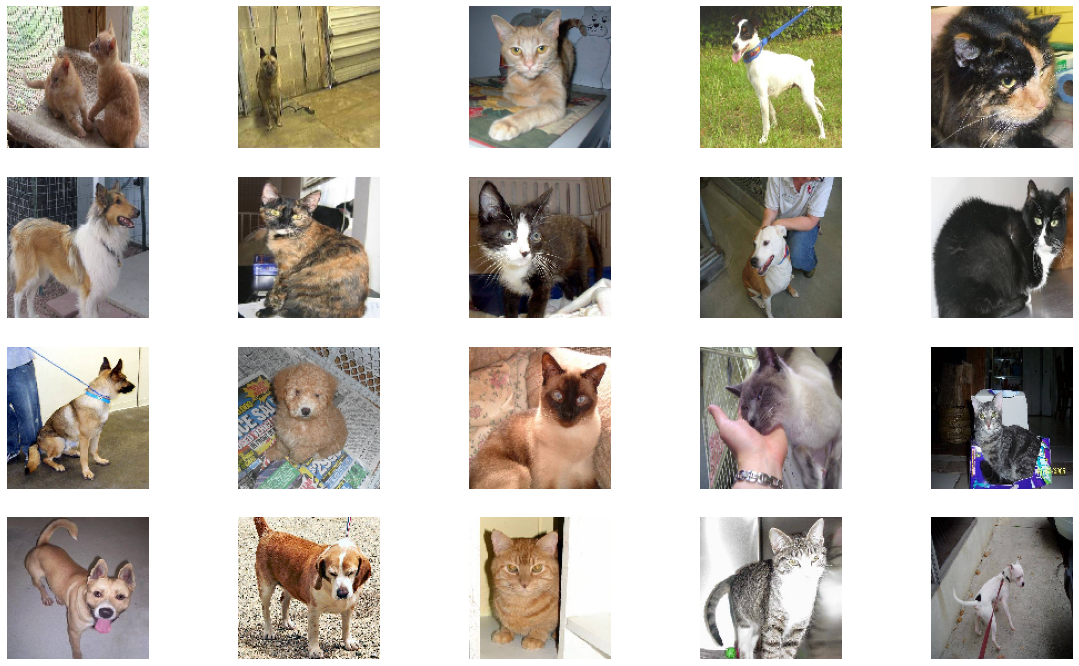

In [82]:
from tensorflow.keras.preprocessing.image import load_img

SHAPE = (4, 5)
FIGSIZE = (20, 12)
N = SHAPE[0] * SHAPE[1]

sample_df = result_df.sample(n=N).reset_index(drop=True)
plt.figure(figsize=FIGSIZE)
for i, row in sample_df.iterrows():
    filename = row["filename"]
    filepath = os.path.join(TEST_DIR, filename)
    type = row["class"]
    image = load_img(filepath, target_size=IMG_SIZE)
    plt.subplot(SHAPE[0], SHAPE[1], i + 1)
    plt.imshow(image)
    plt.xlabel(f"{filename}-{type}")
plt.tight_layout()
plt.show()
